In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.np_utils import to_categorical 

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [237]:
ds = pd.read_pickle('data/state_space.pickle')
ds.pos_neutral = 1.0 # assume we are always neutral
state_cols = list(ds.columns)

In [238]:
remove_cols = [c for c in ds.columns if '_log_returns_0' in c]

In [239]:
for c in remove_cols:
    state_cols.remove(c)

In [241]:
dm = pd.read_pickle('data/master.pickle')
spread = 0.0001

pairs = dm.pair.unique()
dps = {}
for pair in pairs:
    dps[pair] = dm[dm.pair == pair].copy()
    dps[pair]['next_open'] = dps[pair].open.shift(-1)
    dps[pair]['log_change_short'] = np.log((dps[pair].open - spread) / dps[pair].next_open)
    dps[pair]['log_change_neutral'] = 0.0
    dps[pair]['log_change_long'] = np.log(dps[pair].next_open / ( dps[pair].open + spread ))

In [242]:
df = dps['EUR/USD'].join(ds)[~dps['EUR/USD'].join(ds).isna().any(axis=1)]

In [342]:
ver_amnt = int(len(input_data)*0.2)

input_data = np.array(df[state_cols])[:-ver_amnt]
output_data = np.array(df[['log_change_short', 'log_change_neutral', 'log_change_long']])[:-ver_amnt]
#output_data[:,0] + (output_data[:,0] > 0.0004).astype(int)-1
#output_data[:,2] + (output_data[:,2] > 0.0004).astype(int)-1
output_data = to_categorical(np.argmax(output_data, axis=1), num_classes=3)

input_verify = np.array(df[state_cols])[-ver_amnt:]
output_verify = np.array(df[['log_change_short', 'log_change_neutral', 'log_change_long']])[-ver_amnt:]
output_verify = to_categorical(np.argmax(output_verify, axis=1), num_classes=3)

In [343]:
model = Sequential()

model.add(Dense(units=256, activation='elu', input_shape=input_data[0].shape))
model.add(Dense(units=256, activation='elu'))
model.add(Dense(units=256, activation='elu'))
model.add(Dense(units=len(output_data[0]), activation='softmax'))

opt = Adam(lr=0.0025)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [357]:
history = model.fit(input_data, output_data, batch_size=1, epochs=250, verbose=1)
np.save('history', np.array([history.history]))
model.save('nn.h5')

Epoch 1/250
  2934/116420 [..............................] - ETA: 9:15 - loss: 1.0460 - acc: 0.6172

KeyboardInterrupt: 

In [355]:
_preds = model.predict(input_verify)
preds = to_categorical(np.argmax(_preds, axis=1), num_classes=3)

Total: 0.18735240837049977


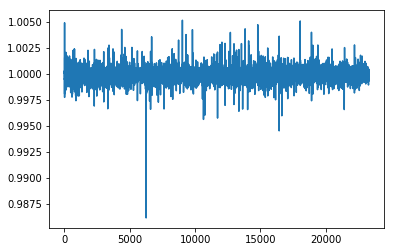

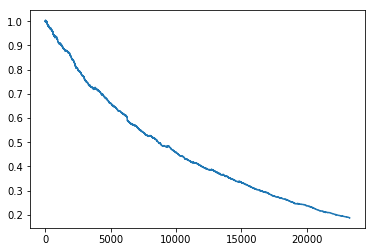

In [356]:
results = []
gains = [1]
for i, (ts, row) in enumerate(df.iloc[-ver_amnt:].iterrows()):
    #print(row)
    action = np.argmax(preds[i])
    #action = np.random.choice([0,1,2])

    if action == 0:
        results.append(row.log_change_short)
    if action == 1:
        results.append(row.log_change_neutral)
    if action == 2:
        results.append(row.log_change_long)
        
    gain = gains[-1] * np.exp(np.sum(results[-1]))
    gains.append(gain)
        
print("Total:", np.exp(np.sum(results)))
    
plt.plot(np.exp(results))
plt.show()
plt.plot(gains)
plt.show()